In [62]:
# Parallel Convolutional Neural Network for multi-class softmax classification

In [63]:
# Import the dependencies

%matplotlib inline
import matplotlib.pyplot as plt #For plots
import pandas as pd #For Dataframes
import numpy as np #For scientific computing 

In [64]:
# Import Keras dependencies

import keras

from keras.models import Sequential, load_model, Model
from keras.utils import to_categorical
from keras import layers
from keras import Input
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [65]:
batch_size = 256
num_classes = 26
epochs = 10
img_rows, img_cols = 28, 28    # Input image dimensions

In [66]:
Emnist_file_path = "emnist/"

In [67]:
# Mapping file for ascii to alphabet mapping

mapping_file = Emnist_file_path + 'emnist-letters-mapping.txt'

In [68]:
# Reading the file into a list

with open(mapping_file, 'r') as fin: 
    mapping = fin.readlines() 
    
# Creating an ascii dictionary

ascii_map = {} 
for line in mapping: 
    char_class = int(line.split()[0]) 
    letter = chr(int(line.split()[1])) 
    ascii_map[char_class] = letter

In [69]:
All_train = Emnist_file_path + 'emnist-letters-train.csv'
All_test = Emnist_file_path + 'emnist-letters-test.csv'

In [70]:
All_train_data = pd.read_csv(All_train)
All_test_data = pd.read_csv(All_test)

In [71]:
All_training_data = All_train_data.values
All_testing_data = All_test_data.values

In [72]:
print(type(All_training_data))
print(type(All_testing_data))
print(All_training_data.shape)
print(All_testing_data.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(88799, 785)
(14799, 785)


In [73]:
x_train = All_training_data[:, 1:].astype('float32')
y_train = All_training_data[:, 0:1]
print('x_train shape : ', x_train.shape)
print('y_train shape : ', y_train.shape)

x_train shape :  (88799, 784)
y_train shape :  (88799, 1)


In [74]:
x_test = All_testing_data[:, 1:].astype('float32')
y_test = All_testing_data[:, 0:1]
print('x_test shape : ', x_test.shape)
print('y_test shape : ', y_test.shape)

x_test shape :  (14799, 784)
y_test shape :  (14799, 1)


In [75]:
# for conv2d
x_train = np.array(list(map(lambda x : x.reshape(28, 28).transpose().reshape(28, 28, 1), x_train)))
x_test = np.array(list(map(lambda x : x.reshape(28, 28).transpose().reshape(28, 28, 1), x_test)))

In [76]:
input_shape = (img_rows, img_cols, 1)

In [77]:
print(type(x_train))
print('x_train shape : ', x_train.shape)

<class 'numpy.ndarray'>
x_train shape :  (88799, 28, 28, 1)


In [78]:
print(type(x_test))
print('x_test shape : ', x_test.shape)

<class 'numpy.ndarray'>
x_test shape :  (14799, 28, 28, 1)


data  9568  :  [12]


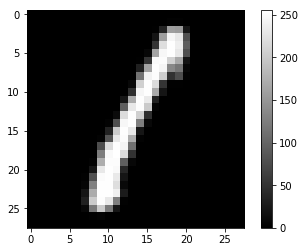

In [79]:
# Print the i data 
i = 9568
plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
plt.colorbar()
print('data ', i, ' : ', y_test[i])

In [80]:
# Make it 0 based indices

y_train = y_train - 1
y_test = y_test - 1

In [81]:
# Scale from 0 to 255

x_train /= 255
x_test /= 255

In [82]:
# Convert labels to categorical one-hot encoding

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [83]:
# # Set the CNN Architecture

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
# # filters: Integer (Here 32), the dimensionality of the output space (i.e. the number of output filters in the convolution).
# # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
# # Can be a single integer to specify the same value for all spatial dimensions.
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(num_classes, activation='softmax'))

In [84]:
# Set the CNN Architecture


input_tensor = Input(shape=input_shape)

#input_noisy = layers.GaussianNoise(.25)(input_tensor)

branch_a = layers.Conv2D(64, (2,6), activation='relu')(input_tensor)
branch_a = layers.AveragePooling2D(pool_size=(2,2))(branch_a)
branch_a = layers.Conv2D(64, (2,2), activation='relu')(branch_a)
branch_a = layers.MaxPooling2D(pool_size=(2,2))(branch_a)
branch_a = layers.Dropout(0.25)(branch_a)
#branch_a = Flatten()(branch_a)

branch_b = layers.Conv2D(64, (6,2), activation='relu')(input_tensor)
branch_b = layers.AveragePooling2D(pool_size=(2,2))(branch_b)
branch_b = layers.Conv2D(64, (2,2), activation='relu')(branch_b)
branch_b = layers.MaxPooling2D(pool_size=(2,2))(branch_b)
branch_b = layers.Dropout(0.25)(branch_b)
branch_b = layers.Reshape((6, 5, 64))(branch_b)
#branch_b = Flatten()(branch_b)

branch_ab = layers.concatenate([branch_a, branch_b], axis=-1)
branch_ab = layers.LocallyConnected2D(64, (3,3), activation='relu')(branch_ab)
branch_ab = layers.Dropout(0.25)(branch_ab)

branch_ab = layers.Flatten()(branch_ab)

dense_layer = layers.Dense(512, activation='relu')(branch_ab)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(512, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.25)(dense_layer)

output_tensor = layers.Dense(num_classes, activation='softmax')(dense_layer)

model = Model(input_tensor, output_tensor)

In [85]:
# Compile the Model

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [86]:
# Summarize our model

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 23, 27, 64)   832         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 27, 23, 64)   832         input_4[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_8 (AveragePoo (None, 11, 13, 64)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
average_po

In [87]:
# Calculate the Classification Accuracy on the Test Set (Before Training)

score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print('Before Training - Test accuracy: %.4f%%' % accuracy)

Before Training - Test accuracy: 5.1558%


In [88]:
checkpointer = ModelCheckpoint(filepath='emnist.letters.cnn_par.model.best.hdf5',
                               verbose=1, save_best_only=True)

In [89]:
# Train the model, iterating on the data in batches of 256 samples with epochs 10

Trained_Model = model.fit(x_train, y_train, batch_size=batch_size, epochs=10,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=3, shuffle=True)

Train on 71039 samples, validate on 17760 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.35520, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 2/10

Epoch 00002: val_loss improved from 0.35520 to 0.27728, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 3/10

Epoch 00003: val_loss improved from 0.27728 to 0.24585, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 4/10

Epoch 00004: val_loss improved from 0.24585 to 0.22390, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 5/10

Epoch 00005: val_loss improved from 0.22390 to 0.21689, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 6/10

Epoch 00006: val_loss improved from 0.21689 to 0.21567, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 7/10

Epoch 00007: val_loss improved from 0.21567 to 0.20326, saving model to emnist.letters.cnn_par.model.best.hdf5
Epoch 8/10

Epoch 00008: val_loss improved from 0.20326 to 0.19927, saving model to emnist.le

In [90]:
# Load the Model with the Best Classification Accuracy on the Validation Set

model.load_weights('emnist.letters.cnn_par.model.best.hdf5')

In [91]:
# Save the best model

model.save('eminst_letters_cnn_par_model.h5')

In [92]:
# Evaluate test accuracy

score = model.evaluate(x_test, y_test, verbose=0)

accuracy = 100*score[1]
loss = 100*score[0]

print('Test accuracy: %.4f%%' % accuracy)
print('Test loss: %.4f%%' % loss)

Test accuracy: 92.8238%
Test loss: 21.9858%


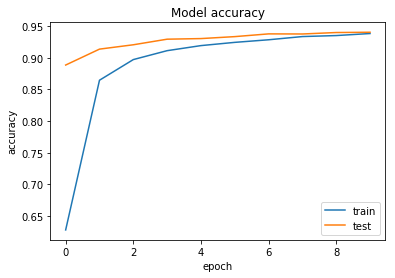

In [146]:
# summarize history for accuracy
plt.plot(Trained_Model.history['acc'])
plt.plot(Trained_Model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

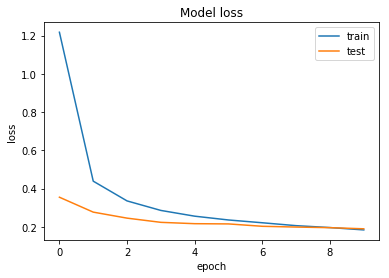

In [145]:
# summarize history for loss
plt.plot(Trained_Model.history['loss'])
plt.plot(Trained_Model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Making Predictions
We can use our trained model to make predictions using model.predict

data  9780  :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


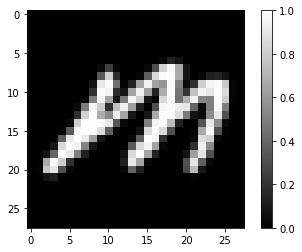

In [131]:
# Print the i data 
i = 9780
plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
plt.colorbar()
print('data ', i, ' : ', y_test[i])

In [133]:
# Use the model to make a prediction
predicted = model.predict(test)[0]
predicted_digit = np.argmax(predicted) + 1
predicted_digit

9

In [134]:
pred_letter = ascii_map[predicted_digit] 
pred_letter

'I'

In [99]:
filepath = "uploads/LetterX.png"

In [100]:
from keras.preprocessing import image
image_size = (28, 28)
im = image.load_img(filepath, target_size=image_size, grayscale=True)
im

C:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [102]:
# Convert the image to a numpy array 
from keras.preprocessing.image import img_to_array
image = img_to_array(im)
image.shape

(28, 28, 1)

In [103]:
# Expand the dimension
image = np.expand_dims(image, axis=0)
image.shape

(1, 28, 28, 1)

In [104]:
# Scale the image pixels by 255 (or use a scaler from sklearn here)
image = (255 - image) / 255

In [143]:
# Use the model to make a prediction
predicted = model.predict(image)[0]
predicted_digit =np.argmax(predicted) + 1
predicted_digit

24

In [144]:
pred_letter = ascii_map[predicted_digit] 
pred_letter

'X'

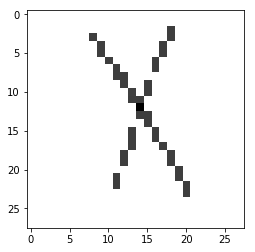

In [107]:
# import matplotlib.pyplot as plt #For plots
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys)

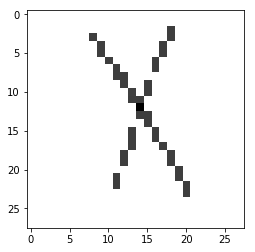

In [110]:
# # Invert the pixel values to match the original data
image = 1 - image
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys)